In [1]:
from torch.utils.data import Dataset

In [2]:
from sklearn.linear_model import Ridge, RidgeCV
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings(action='once')

In [4]:
# pre processing function
def zscale(x, mean, std):
    result = np.subtract(x, mean)
    
    result = np.divide(result, std, out=np.zeros_like(result), where=std!=0)
    
    return result

def norma(x, min, max): 
    result = np.subtract(x, min)
    
    result = np.divide(result, np.subtract(max, min), out=np.zeros_like(result), where=np.subtract(max, min)!=0)
    return result


# model 
# http://web.as.uky.edu/statistics/users/pbreheny/764-f11/notes/9-1.pdf
# slide 3
def ridge_regression(X, y, lam):
    xtranspose = np.transpose(X)
    xtransx = np.dot(xtranspose, X)
    lamidentity = np.identity(xtransx.shape[0]) * lam
    matinv = np.linalg.inv(lamidentity + xtransx)
    xtransy = np.dot(xtranspose, y)
    # return betas
    return np.dot(matinv, xtransy)

In [5]:
class MCVDDataset(Dataset):

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.mcvd_data = pd.read_csv(csv_file)

    def __len__(self):
        return self.mcvd_data.shape[0]

    def __getitem__(self, idx):
        
        data = self.mcvd_data.iloc[idx][6:].values.astype('float32')
        target = (self.mcvd_data.iloc[idx][2])
        sample = {'data': data, 'target': target}

        return sample

In [6]:
def get_valid_train_split(df,split=0.25,randomseed=None, silent=False,minimum =2):
    prodids = df['prodid'].unique()
    train_idx = []
    test_idx = []

    for prodid in prodids:
        if (df[df['prodid'] == prodid].shape[0] <minimum):
            if (not silent):
                print("Skipped prodid {} with {} entries".format(prodid,df[df['prodid'] == prodid].shape[0]))
        else:
            #References
            index = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] == 0)].index
            train,test = train_test_split(index,test_size=split ,random_state=randomseed)
            [train_idx.append(value) for value in train]
            [test_idx.append(value) for value in test]

            #Targets
            index = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] != 0)].index
            train,test = train_test_split(index,test_size=split ,random_state=randomseed)
            [train_idx.append(value) for value in train]
            [test_idx.append(value) for value in test]
            
    return train_idx, test_idx

# Tests

## Raw input data

In [7]:
dataset = MCVDDataset(csv_file='dataset-goldenref.csv')
dataset.mcvd_data = dataset.mcvd_data.drop('Unnamed: 0',axis=1)
dataset.mcvd_data['starttime'] = pd.to_datetime(dataset.mcvd_data['starttime'])

In [8]:
randomseed=23
k_fold=5
split = 0.20
train_idx, test_idx = get_valid_train_split(dataset.mcvd_data,split=split,randomseed=randomseed,silent=True)

In [26]:
X_train = np.empty([0,341])
Y_train = np.empty([0,1])

for idx in train_idx:
    X_train = np.append(X_train,dataset.__getitem__(idx)['data'].reshape(1,341),axis=0)
    Y_train = np.append(Y_train,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    
    
    
X_test = np.empty([0,341])
Y_test = np.empty([0,1])
M_test = np.empty([0,1])
for idx in test_idx:
    X_test = np.append(X_test,dataset.__getitem__(idx)['data'].reshape(1,341),axis=0)
    Y_test = np.append(Y_test,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    M_test =  np.append(M_test,dataset.mcvd_data.iloc[idx,0])


In [27]:
df = dataset.mcvd_data.loc[train_idx].reset_index()
idxcv1 = df.loc[df['adjustment'] !=0].index.values

idxcv2 = df.loc[df['adjustment'] ==0].index.values

cv1 = np.array_split(idxcv1, k_fold)
cv2 = np.array_split(idxcv2, k_fold)


folds = [np.concatenate((cv1[i], cv2[i])) for i in range(k_fold)]

In [28]:
# CV
idx_cv = np.random.choice(np.arange(X_train.shape[0]), replace=False, size=int(X_train.shape[0] * split))


# hyperparamters
n_steps = 2000
my_lambda = np.logspace(start=-5, stop=5, num=n_steps)
dev_loss = np.empty((k_fold, n_steps))


for i, idx_dev_cv in enumerate(folds):
    print("fold: " + str(i+1))

    
    idx_train_cv = np.array([i for i in np.arange(X_train.shape[0]) if not i in idx_dev_cv])
    # create train and dev data
    
    X_train_cv = X_train[idx_train_cv,]
    Y_train_cv = Y_train[idx_train_cv]
    
    X_dev_cv = X_train[idx_dev_cv,]
    Y_dev_cv = Y_train[idx_dev_cv]

    # find properties...
    mean = np.mean(X_train_cv, axis=0)
    std = np.std(X_train_cv, axis=0)
    train_max = np.max(Y_train_cv)
    train_min = np.min(Y_train_cv)
    # min = np.min(X_train_cv, axis=0)
    # max = np.max(X_train_cv, axis=0)
    
    
    # pre-process
    #X_train_cv = zscale(X_train_cv, mean, std)
    #X_dev_cv = zscale(X_dev_cv, mean, std)
    #X_train_cv = norma(X_train_cv, mean, std)
    #X_dev_cv = norma(X_dev_cv, mean, std)
    
    
    for j, lam in enumerate(my_lambda):
        # fit 
        # clf = Ridge(alpha=lam, fit_intercept=False, normalize=True)
        # clf.fit(X_train_cv, Y_train_cv)
        betas = ridge_regression(X_train_cv, Y_train_cv, lam)
        
        # predict and get loss
        # Y_dev_cv_hat = clf.predict(X_dev_cv)
        Y_dev_cv_hat = np.dot(X_dev_cv, betas)
        dev_loss[i,j] = np.sum(np.power(Y_dev_cv - Y_dev_cv_hat,2))
        
        
    print('best MSE:', np.min(dev_loss[i,]))
    print('best lambda:', my_lambda[np.argmin(dev_loss[i,])], '\n')


fold: 1
best MSE: 0.117638874662
best lambda: 27843.4060677 

fold: 2
best MSE: 0.0237854018976
best lambda: 100000.0 

fold: 3
best MSE: 0.0118319582896
best lambda: 100000.0 

fold: 4
best MSE: 0.0216310183759
best lambda: 100000.0 

fold: 5
best MSE: 0.0216217272771
best lambda: 10580.6477499 



In [29]:
# # One std. error rule
# std_means = np.std(dev_loss, axis=0) / np.sqrt(k_fold)
# mse_means = np.mean(dev_loss, axis=0)
# best_idx_std_means = np.argmin(std_means)
# best_idx_std_means = np.max(np.where(std_means[best_idx_std_means] + std_means[best_idx_std_means] > std_means)[0])
# my_lambda_opt = my_lambda[best_idx_std_means]

# # GLOBAL
# my_lambda_opt = my_lambda[np.argmin(np.mean(dev_loss, axis=0))]

# LOCAL
my_lambda_opt = np.mean([my_lambda[np.argmin(dev_loss[i,])] for i in range(dev_loss.shape[0])])
print('the opt. lambda is: ' + str(my_lambda_opt))

# find properties...
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
train_max = np.max(Y_train)
train_min = np.min(Y_train)
# min = np.min(X_train_cv, axis=0)
# max = np.max(X_train_cv, axis=0)

# pre-process
#X_train = zscale(X_train, mean, std)
#X_test = zscale(X_test, mean, std)

#Y_train = norma(Y_train, mean, std)
#Y_test = norma(Y_test, mean, std)

#clf = Ridge(alpha=my_lambda_opt)
#clf.fit(X_train, Y_train)
betas_opt = ridge_regression(X_train, Y_train, lam)
Y_test_hat = np.dot(X_test, betas_opt)
#Y_test_hat = clf.predict(X_test)

print('best MSE:', np.mean(np.power(Y_test - Y_test_hat,2)))



the opt. lambda is: 67684.8107635
best MSE: 0.000454439687166


In [30]:
print('MSE_train: {}'.format(mean_squared_error(Y_train,np.dot(X_train, betas_opt))))
print('MSE_valid: {}'.format(mean_squared_error(Y_test,np.dot(X_test, betas_opt))))


MSE_train: 0.0005898952477351343
MSE_valid: 0.000454439687165606


In [31]:
X_test = np.empty([0,341])
Y_test = np.empty([0,1])
M_test = np.empty([0,1])
for idx in test_idx:
    X_test = np.append(X_test,dataset.__getitem__(idx)['data'].reshape(1,341),axis=0)
    Y_test = np.append(Y_test,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    M_test =  np.append(M_test,dataset.mcvd_data.iloc[idx,0])

# pre-process
#X_test = zscale(X_test, mean, std)
#X_test = norma(X_test, mean, std)

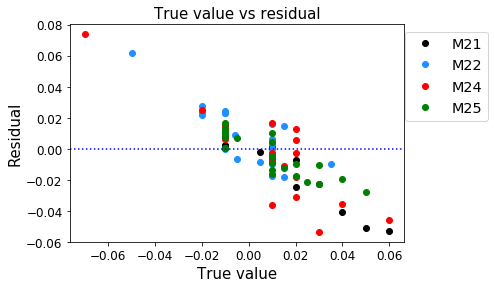

In [32]:
from matplotlib.lines import Line2D
Title = "True value vs residual"
x_label ="True value"
y_label = "Residual"
savename = "Ridge-raw"

custom_lines = [Line2D([0], [0], color='black',marker='o',linestyle='none'),
                Line2D([0], [0], color='dodgerblue',marker='o',linestyle='none'),
                Line2D([0], [0], color='red',marker='o',linestyle='none'),
               Line2D([0], [0], color='green',marker='o',linestyle='none')]

color_map = {'m21' : 'black','m22': 'dodgerblue','m24': 'red','m25':'green'}
preds = np.dot(X_test, betas_opt)


for i,m in enumerate(M_test):
    color = color_map[m]
    plt.plot(Y_test[i],preds[i]-Y_test[i],marker='o', color=color,linestyle='none')
    
    
    
plt.axhline(y=0.0, color='blue', linestyle=':')  
ax = plt.gca()
ax.legend(custom_lines, ['M21', 'M22', 'M24','M25'],bbox_to_anchor=(1.27, 1),fontsize='x-large')
ax.set_xlabel(x_label,size=15)
ax.set_ylabel(y_label,size=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title(Title,size=15)
fig = ax.get_figure()
plt.show()
fig.savefig("{}.pdf".format(savename), bbox_inches='tight')#

In [15]:
# settings
Title = "True value vs residual"
x_label ="True value"
y_label = "Residual"
savename = "Ridge-raw"

plt.plot(S['True'],S['Pred']-S['True'],marker='o', color='dodgerblue',linestyle='none')
ax = plt.gca()
ax.set_xlabel(x_label,size=15)
ax.set_ylabel(y_label,size=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title(Title,size=15)
fig = ax.get_figure()
#fig.savefig("{}.pdf".format(savename), bbox_inches='tight')#

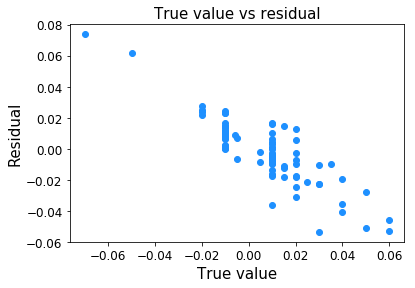

In [16]:
plt.show()

In [15]:
S

MSE_train                                          0.000361334
MSE_valid                                          0.000212982
Pred         [0.0173350552471, 0.000585133882966, 0.0133309...
True         [0.0, 0.0, 0.06, 0.05, 0.0, 0.0, 0.0, -0.01, 0...
dtype: object

##  Raw input, exclude 0

In [16]:
dataset = MCVDDataset(csv_file='dataset.csv')
dataset.mcvd_data = dataset.mcvd_data.drop('Unnamed: 0',axis=1)
dataset.mcvd_data['starttime'] = pd.to_datetime(dataset.mcvd_data['starttime'])
dataset.mcvd_data = dataset.mcvd_data[dataset.mcvd_data['adjustment'] != 0].reset_index(drop=True)

randomseed=23
k_fold=5
split = 0.20
train_idx, test_idx = get_valid_train_split(dataset.mcvd_data,split=split,randomseed=randomseed,silent=True)

X_train = np.empty([0,344])
Y_train = np.empty([0,1])
for idx in train_idx:
    X_train = np.append(X_train,dataset.__getitem__(idx)['data'].reshape(1,344),axis=0)
    Y_train = np.append(Y_train,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    
    
X_test = np.empty([0,344])
Y_test = np.empty([0,1])
for idx in test_idx:
    X_test = np.append(X_test,dataset.__getitem__(idx)['data'].reshape(1,344),axis=0)
    Y_test = np.append(Y_test,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    


df = dataset.mcvd_data.loc[train_idx].reset_index()
idxcv1 = df.loc[df['adjustment'] !=0].index.values

idxcv2 = df.loc[df['adjustment'] ==0].index.values

cv1 = np.array_split(idxcv1, k_fold)
cv2 = np.array_split(idxcv2, k_fold)


folds = [np.concatenate((cv1[i], cv2[i])) for i in range(k_fold)]

# CV
idx_cv = np.random.choice(np.arange(X_train.shape[0]), replace=False, size=int(X_train.shape[0] * split))


# hyperparamters
n_steps = 2000
my_lambda = np.logspace(start=-5, stop=5, num=n_steps)
dev_loss = np.empty((k_fold, n_steps))


for i, idx_dev_cv in enumerate(folds):
    print("fold: " + str(i+1))

    
    idx_train_cv = np.array([i for i in np.arange(X_train.shape[0]) if not i in idx_dev_cv])
    # create train and dev data
    
    X_train_cv = X_train[idx_train_cv,]
    Y_train_cv = Y_train[idx_train_cv]
    
    X_dev_cv = X_train[idx_dev_cv,]
    Y_dev_cv = Y_train[idx_dev_cv]

    # find properties...
    mean = np.mean(X_train_cv, axis=0)
    std = np.std(X_train_cv, axis=0)
    # min = np.min(X_train_cv, axis=0)
    # max = np.max(X_train_cv, axis=0)
    
    
    # pre-process
    #X_train_cv = zscale(X_train_cv, mean, std)
    #X_dev_cv = zscale(X_dev_cv, mean, std)
    # X_train_cv = norma(X_train_cv, mean, std)
    # X_dev_cv = norma(X_dev_cv, mean, std)
    
    
    for j, lam in enumerate(my_lambda):
        # fit 
        # clf = Ridge(alpha=lam, fit_intercept=False, normalize=True)
        # clf.fit(X_train_cv, Y_train_cv)
        betas = ridge_regression(X_train_cv, Y_train_cv, lam)
        
        # predict and get loss
        # Y_dev_cv_hat = clf.predict(X_dev_cv)
        Y_dev_cv_hat = np.dot(X_dev_cv, betas)
        dev_loss[i,j] = np.sum(np.power(Y_dev_cv - Y_dev_cv_hat,2))
        
        
    print('best MSE:', np.min(dev_loss[i,]))
    print('best lambda:', my_lambda[np.argmin(dev_loss[i,])], '\n')


# # One std. error rule
# std_means = np.std(dev_loss, axis=0) / np.sqrt(k_fold)
# mse_means = np.mean(dev_loss, axis=0)
# best_idx_std_means = np.argmin(std_means)
# best_idx_std_means = np.max(np.where(std_means[best_idx_std_means] + std_means[best_idx_std_means] > std_means)[0])
# my_lambda_opt = my_lambda[best_idx_std_means]

# # GLOBAL
# my_lambda_opt = my_lambda[np.argmin(np.mean(dev_loss, axis=0))]

# LOCAL
my_lambda_opt = np.mean([my_lambda[np.argmin(dev_loss[i,])] for i in range(dev_loss.shape[0])])
print('the opt. lambda is: ' + str(my_lambda_opt))

# find properties...
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
# min = np.min(X_train_cv, axis=0)
# max = np.max(X_train_cv, axis=0)

# pre-process
#X_train = zscale(X_train, mean, std)
#X_test = zscale(X_test, mean, std)
# X_train = norma(X_train, mean, std)
# X_test = norma(X_test, mean, std)

#clf = Ridge(alpha=my_lambda_opt)
#clf.fit(X_train, Y_train)
betas_opt = ridge_regression(X_train, Y_train, lam)
Y_test_hat = np.dot(X_test, betas_opt)
#Y_test_hat = clf.predict(X_test)

print('best MSE:', np.mean(np.power(Y_test - Y_test_hat,2)))





S = pd.Series({'MSE_train' : mean_squared_error(Y_train,np.dot(X_train, betas_opt)),
                   'MSE_valid' : mean_squared_error(Y_test,np.dot(X_test, betas_opt)),
                   'Pred' : np.dot(X_test, betas_opt).reshape(-1),
                   'True' : Y_test.reshape(-1)})

# settings
Title = "True value vs residual"
x_label ="True value"
y_label = "Residual"
savename = "Ridge-raw-excl0"

plt.plot(S['True'],S['Pred']-S['True'],marker='o', color='dodgerblue',linestyle='none')
ax = plt.gca()
ax.set_xlabel(x_label,size=15)
ax.set_ylabel(y_label,size=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title(Title,size=15)
fig = ax.get_figure()
fig.savefig("{}.pdf".format(savename), bbox_inches='tight')#

fold: 1
best MSE: 0.156135644841
best lambda: 43633.4858587 

fold: 2
best MSE: 0.0244054674076
best lambda: 100000.0 

fold: 3
best MSE: 0.0180149747595
best lambda: 100000.0 

fold: 4
best MSE: 0.0406224775806
best lambda: 57528.0879853 

fold: 5
best MSE: 0.0320738325323
best lambda: 100000.0 

the opt. lambda is: 80232.3147688
best MSE: 0.000402137872537


In [17]:
S

MSE_train                                          0.000701733
MSE_valid                                          0.000402138
Pred         [0.0243597413421, 0.0184859864039, 0.008361346...
True         [0.06, 0.05, -0.01, 0.04, 0.03, 0.01, 0.02, 0....
dtype: object

## Normalized input data

In [18]:
min_max_scaler = MinMaxScaler()
dataset = MCVDDataset(csv_file='dataset.csv')
dataset.mcvd_data = dataset.mcvd_data.drop('Unnamed: 0',axis=1)
dataset.mcvd_data.iloc[:,6:306] = min_max_scaler.fit_transform(dataset.mcvd_data.iloc[:,6:306].T).T
dataset.mcvd_data['starttime'] = pd.to_datetime(dataset.mcvd_data['starttime'])

randomseed=23
k_fold=5
split = 0.20
train_idx, test_idx = get_valid_train_split(dataset.mcvd_data,split=split,randomseed=randomseed,silent=True)

X_train = np.empty([0,344])
Y_train = np.empty([0,1])
for idx in train_idx:
    X_train = np.append(X_train,dataset.__getitem__(idx)['data'].reshape(1,344),axis=0)
    Y_train = np.append(Y_train,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    
    
X_test = np.empty([0,344])
Y_test = np.empty([0,1])
for idx in test_idx:
    X_test = np.append(X_test,dataset.__getitem__(idx)['data'].reshape(1,344),axis=0)
    Y_test = np.append(Y_test,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    


df = dataset.mcvd_data.loc[train_idx].reset_index()
idxcv1 = df.loc[df['adjustment'] !=0].index.values

idxcv2 = df.loc[df['adjustment'] ==0].index.values

cv1 = np.array_split(idxcv1, k_fold)
cv2 = np.array_split(idxcv2, k_fold)


folds = [np.concatenate((cv1[i], cv2[i])) for i in range(k_fold)]

# CV
idx_cv = np.random.choice(np.arange(X_train.shape[0]), replace=False, size=int(X_train.shape[0] * split))


# hyperparamters
n_steps = 2000
my_lambda = np.logspace(start=-5, stop=5, num=n_steps)
dev_loss = np.empty((k_fold, n_steps))


for i, idx_dev_cv in enumerate(folds):
    print("fold: " + str(i+1))

    
    idx_train_cv = np.array([i for i in np.arange(X_train.shape[0]) if not i in idx_dev_cv])
    # create train and dev data
    
    X_train_cv = X_train[idx_train_cv,]
    Y_train_cv = Y_train[idx_train_cv]
    
    X_dev_cv = X_train[idx_dev_cv,]
    Y_dev_cv = Y_train[idx_dev_cv]

    # find properties...
    mean = np.mean(X_train_cv, axis=0)
    std = np.std(X_train_cv, axis=0)
    # min = np.min(X_train_cv, axis=0)
    # max = np.max(X_train_cv, axis=0)
    
    
    # pre-process
    #X_train_cv = zscale(X_train_cv, mean, std)
    #X_dev_cv = zscale(X_dev_cv, mean, std)
    # X_train_cv = norma(X_train_cv, mean, std)
    # X_dev_cv = norma(X_dev_cv, mean, std)
    
    
    for j, lam in enumerate(my_lambda):
        # fit 
        # clf = Ridge(alpha=lam, fit_intercept=False, normalize=True)
        # clf.fit(X_train_cv, Y_train_cv)
        betas = ridge_regression(X_train_cv, Y_train_cv, lam)
        
        # predict and get loss
        # Y_dev_cv_hat = clf.predict(X_dev_cv)
        Y_dev_cv_hat = np.dot(X_dev_cv, betas)
        dev_loss[i,j] = np.sum(np.power(Y_dev_cv - Y_dev_cv_hat,2))
        
        
    print('best MSE:', np.min(dev_loss[i,]))
    print('best lambda:', my_lambda[np.argmin(dev_loss[i,])], '\n')


# # One std. error rule
# std_means = np.std(dev_loss, axis=0) / np.sqrt(k_fold)
# mse_means = np.mean(dev_loss, axis=0)
# best_idx_std_means = np.argmin(std_means)
# best_idx_std_means = np.max(np.where(std_means[best_idx_std_means] + std_means[best_idx_std_means] > std_means)[0])
# my_lambda_opt = my_lambda[best_idx_std_means]

# # GLOBAL
# my_lambda_opt = my_lambda[np.argmin(np.mean(dev_loss, axis=0))]

# LOCAL
my_lambda_opt = np.mean([my_lambda[np.argmin(dev_loss[i,])] for i in range(dev_loss.shape[0])])
print('the opt. lambda is: ' + str(my_lambda_opt))

# find properties...
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
# min = np.min(X_train_cv, axis=0)
# max = np.max(X_train_cv, axis=0)

# pre-process
#X_train = zscale(X_train, mean, std)
#X_test = zscale(X_test, mean, std)
# X_train = norma(X_train, mean, std)
# X_test = norma(X_test, mean, std)

#clf = Ridge(alpha=my_lambda_opt)
#clf.fit(X_train, Y_train)
betas_opt = ridge_regression(X_train, Y_train, lam)
Y_test_hat = np.dot(X_test, betas_opt)
#Y_test_hat = clf.predict(X_test)

print('best MSE:', np.mean(np.power(Y_test - Y_test_hat,2)))





S = pd.Series({'MSE_train' : mean_squared_error(Y_train,np.dot(X_train, betas_opt)),
                   'MSE_valid' : mean_squared_error(Y_test,np.dot(X_test, betas_opt)),
                   'Pred' : np.dot(X_test, betas_opt).reshape(-1),
                   'True' : Y_test.reshape(-1)})

# settings
Title = "True value vs residual"
x_label ="True value"
y_label = "Residual"
savename = "Ridge-norm"

plt.plot(S['True'],S['Pred']-S['True'],marker='o', color='dodgerblue',linestyle='none')
ax = plt.gca()
ax.set_xlabel(x_label,size=15)
ax.set_ylabel(y_label,size=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title(Title,size=15)
fig = ax.get_figure()
fig.savefig("{}.pdf".format(savename), bbox_inches='tight')#

fold: 1
best MSE: 0.133547756038
best lambda: 11.1692500051 

fold: 2
best MSE: 0.0221533451849
best lambda: 353.813489813 

fold: 3
best MSE: 0.015181649293
best lambda: 0.875933700488 

fold: 4
best MSE: 0.014060140248
best lambda: 10827.2274109 

fold: 5
best MSE: 0.0135557890361
best lambda: 100000.0 

the opt. lambda is: 22238.6172169
best MSE: 0.000233060507628


In [19]:
S

MSE_train                                          0.000374857
MSE_valid                                          0.000233061
Pred         [0.000496754995387, 0.000499962101037, 0.00049...
True         [0.0, 0.0, 0.06, 0.05, 0.0, 0.0, 0.0, -0.01, 0...
dtype: object

# Normalized excluding 0

In [20]:
dataset = MCVDDataset(csv_file='dataset.csv')
dataset.mcvd_data = dataset.mcvd_data.drop('Unnamed: 0',axis=1)
dataset.mcvd_data.iloc[:,6:306] = min_max_scaler.fit_transform(dataset.mcvd_data.iloc[:,6:306].T).T
dataset.mcvd_data['starttime'] = pd.to_datetime(dataset.mcvd_data['starttime'])
dataset.mcvd_data = dataset.mcvd_data[dataset.mcvd_data['adjustment'] != 0].reset_index(drop=True)

randomseed=23
k_fold=5
split = 0.20
train_idx, test_idx = get_valid_train_split(dataset.mcvd_data,split=split,randomseed=randomseed,silent=True)

X_train = np.empty([0,344])
Y_train = np.empty([0,1])
for idx in train_idx:
    X_train = np.append(X_train,dataset.__getitem__(idx)['data'].reshape(1,344),axis=0)
    Y_train = np.append(Y_train,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    
    
X_test = np.empty([0,344])
Y_test = np.empty([0,1])
for idx in test_idx:
    X_test = np.append(X_test,dataset.__getitem__(idx)['data'].reshape(1,344),axis=0)
    Y_test = np.append(Y_test,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    


df = dataset.mcvd_data.loc[train_idx].reset_index()
idxcv1 = df.loc[df['adjustment'] !=0].index.values

idxcv2 = df.loc[df['adjustment'] ==0].index.values

cv1 = np.array_split(idxcv1, k_fold)
cv2 = np.array_split(idxcv2, k_fold)


folds = [np.concatenate((cv1[i], cv2[i])) for i in range(k_fold)]

# CV
idx_cv = np.random.choice(np.arange(X_train.shape[0]), replace=False, size=int(X_train.shape[0] * split))


# hyperparamters
n_steps = 2000
my_lambda = np.logspace(start=-5, stop=5, num=n_steps)
dev_loss = np.empty((k_fold, n_steps))


for i, idx_dev_cv in enumerate(folds):
    print("fold: " + str(i+1))

    
    idx_train_cv = np.array([i for i in np.arange(X_train.shape[0]) if not i in idx_dev_cv])
    # create train and dev data
    
    X_train_cv = X_train[idx_train_cv,]
    Y_train_cv = Y_train[idx_train_cv]
    
    X_dev_cv = X_train[idx_dev_cv,]
    Y_dev_cv = Y_train[idx_dev_cv]

    # find properties...
    mean = np.mean(X_train_cv, axis=0)
    std = np.std(X_train_cv, axis=0)
    # min = np.min(X_train_cv, axis=0)
    # max = np.max(X_train_cv, axis=0)
    
    
    # pre-process
    #X_train_cv = zscale(X_train_cv, mean, std)
    #X_dev_cv = zscale(X_dev_cv, mean, std)
    # X_train_cv = norma(X_train_cv, mean, std)
    # X_dev_cv = norma(X_dev_cv, mean, std)
    
    
    for j, lam in enumerate(my_lambda):
        # fit 
        # clf = Ridge(alpha=lam, fit_intercept=False, normalize=True)
        # clf.fit(X_train_cv, Y_train_cv)
        betas = ridge_regression(X_train_cv, Y_train_cv, lam)
        
        # predict and get loss
        # Y_dev_cv_hat = clf.predict(X_dev_cv)
        Y_dev_cv_hat = np.dot(X_dev_cv, betas)
        dev_loss[i,j] = np.sum(np.power(Y_dev_cv - Y_dev_cv_hat,2))
        
        
    print('best MSE:', np.min(dev_loss[i,]))
    print('best lambda:', my_lambda[np.argmin(dev_loss[i,])], '\n')


# # One std. error rule
# std_means = np.std(dev_loss, axis=0) / np.sqrt(k_fold)
# mse_means = np.mean(dev_loss, axis=0)
# best_idx_std_means = np.argmin(std_means)
# best_idx_std_means = np.max(np.where(std_means[best_idx_std_means] + std_means[best_idx_std_means] > std_means)[0])
# my_lambda_opt = my_lambda[best_idx_std_means]

# # GLOBAL
# my_lambda_opt = my_lambda[np.argmin(np.mean(dev_loss, axis=0))]

# LOCAL
my_lambda_opt = np.mean([my_lambda[np.argmin(dev_loss[i,])] for i in range(dev_loss.shape[0])])
print('the opt. lambda is: ' + str(my_lambda_opt))

# find properties...
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
# min = np.min(X_train_cv, axis=0)
# max = np.max(X_train_cv, axis=0)

# pre-process
#X_train = zscale(X_train, mean, std)
#X_test = zscale(X_test, mean, std)
# X_train = norma(X_train, mean, std)
# X_test = norma(X_test, mean, std)

#clf = Ridge(alpha=my_lambda_opt)
#clf.fit(X_train, Y_train)
betas_opt = ridge_regression(X_train, Y_train, lam)
Y_test_hat = np.dot(X_test, betas_opt)
#Y_test_hat = clf.predict(X_test)

print('best MSE:', np.mean(np.power(Y_test - Y_test_hat,2)))





S = pd.Series({'MSE_train' : mean_squared_error(Y_train,np.dot(X_train, betas_opt)),
                   'MSE_valid' : mean_squared_error(Y_test,np.dot(X_test, betas_opt)),
                   'Pred' : np.dot(X_test, betas_opt).reshape(-1),
                   'True' : Y_test.reshape(-1)})

# settings
Title = "True value vs residual"
x_label ="True value"
y_label = "Residual"
savename = "Ridge-norm-excl0"

plt.plot(S['True'],S['Pred']-S['True'],marker='o', color='dodgerblue',linestyle='none')
ax = plt.gca()
ax.set_xlabel(x_label,size=15)
ax.set_ylabel(y_label,size=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title(Title,size=15)

fig = ax.get_figure()
fig.savefig("{}.pdf".format(savename), bbox_inches='tight')#
#ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0),size=14)

fold: 1
best MSE: 0.133204646864
best lambda: 3.65410809742 

fold: 2
best MSE: 0.0220835961156
best lambda: 187.774588281 

fold: 3
best MSE: 0.0143247820022
best lambda: 0.42886060911 

fold: 4
best MSE: 0.0138444669485
best lambda: 5424.5933046 

fold: 5
best MSE: 0.0135430934889
best lambda: 100000.0 

the opt. lambda is: 21123.2901723
best MSE: 0.00048180168611


In [21]:
S

MSE_train                                             0.000749
MSE_valid                                          0.000481802
Pred         [0.000665413014304, 0.000666494694588, 0.00067...
True         [0.06, 0.05, -0.01, 0.04, 0.03, 0.01, 0.02, 0....
dtype: object